## Initial setup

In [ ]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random
import types
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed, ProjectConfiguration # Import ProjectConfiguration from accelerate.utils
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


import shutil
import warnings
from pathlib import Path
from packaging import version


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


#### Load images from  google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
drive_path = '/content/gdrive/MyDrive/genai'
dataset = '/content/gdrive/MyDrive/genai/dataset'
images_path = dataset + '/batman'

if not os.path.exists(images_path):
  print(f"Error: The path '{images_path}' does not exist.")

save_path = images_path

#Local uploded images

In [ ]:
# images_path = "batman"
# while not os.path.exists(str(images_path)):
#   print('The images_path specified does not exist, use the colab file explorer to copy the path :')
#   images_path=input("")
# save_path = images_path

##Training

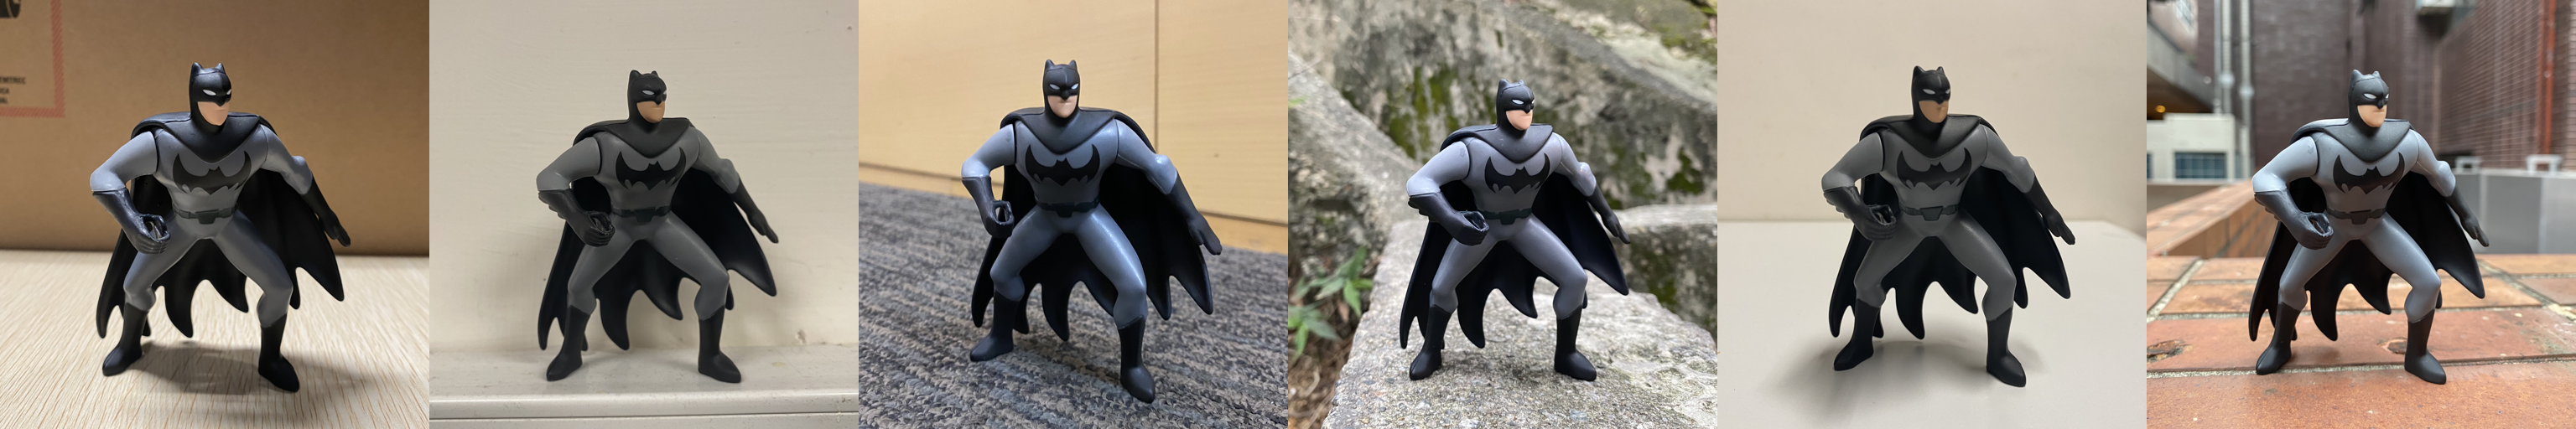

In [ ]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [ ]:
if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
    PIL_INTERPOLATION = {
        "linear": PIL.Image.Resampling.BILINEAR,
        "bilinear": PIL.Image.Resampling.BILINEAR,
        "bicubic": PIL.Image.Resampling.BICUBIC,
        "lanczos": PIL.Image.Resampling.LANCZOS,
        "nearest": PIL.Image.Resampling.NEAREST,
    }
else:
    PIL_INTERPOLATION = {
        "linear": PIL.Image.LINEAR,
        "bilinear": PIL.Image.BILINEAR,
        "bicubic": PIL.Image.BICUBIC,
        "lanczos": PIL.Image.LANCZOS,
        "nearest": PIL.Image.NEAREST,
    }

In [ ]:
def save_progress(text_encoder, placeholder_token, placeholder_token_id, accelerator, save_path):
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)


In [ ]:
#@title Setup the prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [ ]:
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            (
                h,
                w,
            ) = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
#batman
train_data_dir = "./batman"
placeholder_token = "<batman>"
initializer_token = "batman"
learnable_property = "object"
output_dir = "batman_output"
pretrained_model_name_or_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"

seed = 42
train_batch_size = 4
num_train_epochs = 20
max_train_steps = 50

no_safe_serialization = True
repeats = 100
save_steps = 25
save_as_full_pipeline = False
num_vectors = 1
revision = None
variant = None
tokenizer_name = None
resolution = 512
center_crop = False
gradient_accumulation_steps = 4
gradient_checkpointing = False
learning_rate = 5.0e-04
scale_lr = True
lr_scheduler_type = "constant"
lr_warmup_steps = 0
lr_num_cycles = 1
dataloader_num_workers = 0
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_weight_decay = 1e-2
adam_epsilon = 1e-08
push_to_hub = False
hub_token = None
hub_model_id = None
logging_dir = "logs"
mixed_precision = "fp16"
allow_tf32 = False
report_to = "tensorboard"
validation_prompt = None
num_validation_images = 4
validation_steps = 100
validation_epochs = None
local_rank = -1
checkpointing_steps = 500
checkpoints_total_limit = None
resume_from_checkpoint = None
enable_xformers_memory_efficient_attention = False

In [ ]:

# Set up Accelerator
logging_dir = os.path.join("text-inversion-model", "logs")
accelerator_project_config = ProjectConfiguration(project_dir="text-inversion-model", logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
    mixed_precision=mixed_precision,
    log_with="tensorboard",
    project_config=accelerator_project_config,
)

if torch.backends.mps.is_available():
    accelerator.native_amp = False

if accelerator.is_local_main_process:
    import transformers, diffusers
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    import transformers, diffusers
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

if seed is not None:
    torch.manual_seed(seed)

if accelerator.is_main_process and output_dir is not None:
    os.makedirs(output_dir, exist_ok=True)
    if push_to_hub:
        from huggingface_hub import create_repo
        repo_id = create_repo(
            repo_id=hub_model_id or Path(output_dir).name, exist_ok=True, token=hub_token
        ).repo_id

# Load tokenizer
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", revision=revision)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

# Add placeholder tokens
placeholder_tokens = [placeholder_token]
additional_tokens = [f"{placeholder_token}_{i}" for i in range(1, num_vectors)]
placeholder_tokens += additional_tokens

num_added_tokens = tokenizer.add_tokens(placeholder_tokens)
if num_added_tokens != num_vectors:
    raise ValueError(f"The tokenizer already contains the token {placeholder_token}. Please use a different token.")

token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")
initializer_token_id = token_ids[0]
placeholder_token_ids = tokenizer.convert_tokens_to_ids(placeholder_tokens)

text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
with torch.no_grad():
    for token_id in placeholder_token_ids:
        token_embeds[token_id] = token_embeds[initializer_token_id].clone()

# Freeze vae and unet
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.text_model.encoder.requires_grad_(False)
text_encoder.text_model.final_layer_norm.requires_grad_(False)
text_encoder.text_model.embeddings.position_embedding.requires_grad_(False)

if gradient_checkpointing:
    unet.train()
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

if enable_xformers_memory_efficient_attention:
    import xformers
    unet.enable_xformers_memory_efficient_attention()

if allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if scale_lr:
    learning_rate_scaled = learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
else:
    learning_rate_scaled = learning_rate

optimizer = torch.optim.AdamW(
    text_encoder.get_input_embeddings().parameters(),
    lr=learning_rate_scaled,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

# Dataset and DataLoader
train_dataset = TextualInversionDataset(
    data_root=save_path,
    tokenizer=tokenizer,
    size=resolution,
    placeholder_token=" ".join(tokenizer.convert_ids_to_tokens(placeholder_token_ids)),
    repeats=repeats,
    learnable_property=learnable_property,
    center_crop=center_crop,
    set="train",
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=dataloader_num_workers
)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
if max_train_steps is None:
    max_train_steps_calculated = num_train_epochs * num_update_steps_per_epoch
else:
    max_train_steps_calculated = max_train_steps

lr_scheduler = get_scheduler(
    lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps * accelerator.num_processes,
    num_training_steps=max_train_steps_calculated * accelerator.num_processes,
    num_cycles=lr_num_cycles,
)

text_encoder.train()
text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    text_encoder, optimizer, train_dataloader, lr_scheduler
)

weight_dtype = torch.float32
if mixed_precision == "fp16":
    weight_dtype = torch.float16
elif mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

global_step = 0
first_epoch = 0
progress_bar = tqdm(
    range(max_train_steps_calculated),
    initial=0,
    desc="Steps",
    disable=not accelerator.is_local_main_process,
)

orig_embeds_params = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight.data.clone()

for epoch in range(first_epoch, num_train_epochs):
    text_encoder.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(text_encoder):
            latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
            latents = latents * vae.config.scaling_factor
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(batch["input_ids"])[0].to(dtype=weight_dtype)
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            else:
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            index_no_updates = torch.ones((len(tokenizer),), dtype=torch.bool)
            index_no_updates[min(placeholder_token_ids) : max(placeholder_token_ids) + 1] = False
            with torch.no_grad():
                accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[index_no_updates] = orig_embeds_params[index_no_updates]

        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1
            if global_step % save_steps == 0:
                weight_name = f"learned_embeds-steps-{global_step}.bin" if no_safe_serialization else f"learned_embeds-steps-{global_step}.safetensors"
                save_path = os.path.join(output_dir, weight_name)
                save_progress(text_encoder, placeholder_token, placeholder_token_ids, accelerator, save_path)

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= max_train_steps_calculated:
            break

accelerator.wait_for_everyone()
if accelerator.is_main_process:
    weight_name = "learned_embeds.bin" if no_safe_serialization else "learned_embeds.safetensors"
    save_path = os.path.join(output_dir, weight_name)
    save_progress(text_encoder, placeholder_token, placeholder_token_ids, accelerator, save_path)

{'sample_max_value', 'variance_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'thresholding', 'rescale_betas_zero_snr', 'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'latents_mean', 'force_upcast', 'shift_factor', 'mid_block_add_attention', 'use_post_quant_conv', 'latents_std', 'scaling_factor', 'use_quant_conv'} was not found in config. Values will be initialized to default values.
All model checkpoint weights were used when initializing AutoencoderKL.

All the weights of AutoencoderKL were initialized from the model checkpoint at stable-diffusion-v1-5/stable-diffusion-v1-5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use AutoencoderKL for predictions without further training.
{'resnet_out_scale_factor', 'encoder_hid_dim_type', 'time_embedding_act_fn', 'addition_time_embed_dim', 'num_attention_heads', 'cross_attention_norm', 'projection_class_embeddings_input

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Save the training output folder to Google Drive

drive_save_path = os.path.join(drive_path, output_dir)

if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)

shutil.copytree(output_dir, drive_save_path, dirs_exist_ok=True)
print(f"Training output saved to: {drive_save_path}")

Training output saved to: /content/gdrive/MyDrive/genai/batman_output


## Run inference

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path,torch_dtype=torch.float16).to("cuda")

repo_id_embeds = output_dir

# Try loading from local output directory
try:
    pipe.load_textual_inversion(repo_id_embeds)
except Exception as e:
    # If not found locally, try loading from Google Drive
    drive_embeds_path = os.path.join(drive_path, output_dir)
    pipe.load_textual_inversion(drive_embeds_path)

prompt = "A <batman> giraffe"
image = pipe(prompt, num_inference_steps=20, guidance_scale=7.5).images[0]
image.save("batman2.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


  0%|          | 0/20 [00:00<?, ?it/s]

## Metric evaluation

In [ ]:
# Install evaluation dependencies (OpenAI CLIP and OpenCLIP). Re-run if environment resets.
%pip -q install git+https://github.com/openai/CLIP.git open-clip-torch --upgrade


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.3 MB/s eta 0:00:00


In [ ]:
base_model_path = pretrained_model_name_or_path
ti_embeds_dir = output_dir

json_path = os.path.join(drive_path, "evaluation_prompts.json")

eval_outputs_dir = "eval_output_batman"
os.makedirs(eval_outputs_dir, exist_ok=True)

# Evaluation knobs
num_images_per_prompt = 2
num_inference_steps = 15

# limit number of prompts; set to None to run all
max_prompts = 20

In [ ]:
import sys

sys.path.append(drive_path)
from evaluation_code import Evaluator

# Create evaluator (it will build an SD pipeline internally)
evaluator = Evaluator(
    model_path=base_model_path,
    json_path=json_path,
    output_dir=eval_outputs_dir,
    num_images_per_prompt=num_images_per_prompt,
)

if evaluator.device == "cpu":
    pipe_cpu = StableDiffusionPipeline.from_pretrained(base_model_path, torch_dtype=torch.float32)
    evaluator.pipe = pipe_cpu.to(evaluator.device)

# Load learned textual inversion embeddings into the pipeline
try:
    evaluator.pipe.load_textual_inversion(output_dir)
except Exception as e:
    drive_embeds_path = os.path.join(drive_path, output_dir)
    evaluator.pipe.load_textual_inversion(drive_embeds_path)


# Patch _generate_images to use fewer diffusion steps for speed
def _generate_images_fast(self, prompt: str):
    images = []
    for _ in range(self.num_images):
        img = self.pipe(prompt, guidance_scale=7.5, num_inference_steps=num_inference_steps).images[0]
        images.append(img)
    return images

evaluator._generate_images = types.MethodType(_generate_images_fast, evaluator)

if max_prompts is not None and max_prompts > 0:
    evaluator.prompts = evaluator.prompts[:max_prompts]
    print(f"Using a subset of prompts: {len(evaluator.prompts)}")
else:
    print(f"Using all prompts: {len(evaluator.prompts)}")

{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction_type', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
Loaded scheduler as PNDMScheduler from `scheduler` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
Instantiating UNet2DConditionModel model under default dtype torch.float16.
{'resnet_out_scale_factor', 'encoder_hid_dim_type', 'time_embedding_act_fn', 'addition_time_embed_dim', 'num_attention_heads', 'cross_attention_norm', 'projection_class_embeddings_input_dim', 'resnet_time_scale_shift', 'class_embed_type', 'addition_embed_type_num_heads', 'mid_block_type', 'encoder_hid_dim', 'resnet_skip_tim

Loaded textual inversion embedding for <batman>.


Using a subset of prompts: 20


In [ ]:
# Run evaluation
scores = evaluator.evaluate()
print("\n=== Mean Evaluation Metrics ===")
for k, v in scores.items():
    print(f"{k}: {v:.4f}" if v is not None else f"{k}: N/A")
print(f"\nImages saved to: {eval_outputs_dir}")




Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:   5%|▌         | 1/20 [00:05<01:46,  5.63s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  10%|█         | 2/20 [00:11<01:40,  5.60s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  15%|█▌        | 3/20 [00:16<01:34,  5.57s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  20%|██        | 4/20 [00:22<01:29,  5.59s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  25%|██▌       | 5/20 [00:28<01:24,  5.63s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  30%|███       | 6/20 [00:33<01:18,  5.60s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  35%|███▌      | 7/20 [00:39<01:12,  5.56s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  40%|████      | 8/20 [00:44<01:06,  5.51s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  45%|████▌     | 9/20 [00:49<01:00,  5.47s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  50%|█████     | 10/20 [00:55<00:54,  5.42s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  55%|█████▌    | 11/20 [01:00<00:48,  5.39s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  60%|██████    | 12/20 [01:05<00:43,  5.39s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  65%|██████▌   | 13/20 [01:11<00:37,  5.37s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  70%|███████   | 14/20 [01:16<00:32,  5.37s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  75%|███████▌  | 15/20 [01:21<00:26,  5.36s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  80%|████████  | 16/20 [01:27<00:21,  5.35s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  85%|████████▌ | 17/20 [01:32<00:16,  5.38s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  90%|█████████ | 18/20 [01:38<00:10,  5.38s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating:  95%|█████████▌| 19/20 [01:43<00:05,  5.41s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]



Evaluating: 100%|██████████| 20/20 [01:48<00:00,  5.45s/it]


=== Mean Evaluation Metrics ===
CLIP-I: 0.7870
CLIP-T: 0.3736
DINO: 0.7347

Images saved to: eval_output_batman


In [ ]:
drive_eval_save_path = os.path.join(drive_path, eval_outputs_dir)

if not os.path.exists(drive_eval_save_path):
    os.makedirs(drive_eval_save_path)

# Copy the contents of the evaluation output directory to Google Drive
shutil.copytree(eval_outputs_dir, drive_eval_save_path, dirs_exist_ok=True)

print(f"Evaluation output saved to: {drive_eval_save_path}")

Evaluation output saved to: /content/gdrive/MyDrive/genai/eval_output_batman
